# Life Fairness Demo

End-to-end walkthrough: generate synthetic life underwriting data, fit GLM / NN / adversarial NN models to predict **one-year mortality risk**, and then derive **underwriting decline** decisions by flagging the top 2% highest-risk policies. We evaluate accuracy and fairness of these decline decisions across Race A/B (with territory and credit score proxy effects).

## 1. Setup

In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / "src").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print(f"Using project root: {PROJECT_ROOT}")

Using project root: C:\Users\hotfo\bias_mitigation_insurance_pricing


In [2]:
from __future__ import annotations

import numpy as np
import pandas as pd
import torch
from dataclasses import replace
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

from src.life.data_generation_life import (
    generate_life_underwriting_data,
    train_test_split_life,
)
from src.config import TrainingConfig
from src.evaluation.metrics import compute_accuracy_metrics
from src.evaluation.fairness import fairness_metrics, fairness_at_target_rate
from src.models.glm_model import GLMClassifier
from src.models.nn_model import PlainNN, train_plain_nn, predict_proba_plain_nn
from src.models.adv_nn_model import AdvPredictor, train_adv_nn, predict_proba_adv_nn

## 2. Generate Life Data

We use the Life DGP to simulate **mortality risk** and then derive underwriting **decline** decisions:

- Features: Age, BMI, smoker S, chronic flag C, risky occupation R, observed credit Z, and territory T.
- Latent / audit-only: Race (A/B) and latent credit Z*.
- Target: one-year mortality Y in {0,1} (Y = 1 = death / adverse event).

The true risk rule depends on Age, BMI, S, C, R, and **latent** Z* (race-neutral). Models only observe Z (biased) and the proxy T. We then define underwriting decisions by declining the top 2% highest-risk policies based on each model's scores.

In [3]:
df = generate_life_underwriting_data(n_samples=100_000, seed=123)
print(f"Dataset size: {len(df):,}")
df.head()

Dataset size: 100,000


,Age,BMI,S,C,R,Z,T,Y,Race,Z_star,BMI_cat
0,36.723343,31.445601,0,1,1,572.628564,1,0,A,606.446351,2
1,41.116834,19.285569,1,0,0,788.088459,0,0,B,765.105469,0
2,55.681394,28.392383,1,0,0,721.141338,1,0,B,755.330667,1
3,40.537163,25.158097,0,0,0,669.692265,0,0,B,620.452243,1
4,66.953875,28.000590,0,0,0,645.146233,1,1,B,626.387414,1


### 2.1 Sanity Checks: Proxy T, Biased Z, and BMI-Race Correlation

We verify the designed channels:
- T is correlated with Race (proxy).
- Observed credit Z is systematically lower for Race A, even though Z* is race-neutral.
- Race A has a higher fraction of overweight/obese BMI than Race B.

In [4]:
# Territory by Race
print("E[T | Race]:")
print(df.groupby("Race")["T"].mean())

# Observed vs latent credit by Territory
print("\nE[Z | T] and E[Z_star | T]:")
print(df.groupby("T")[['Z', 'Z_star']].mean())

# Event rate by Race
print("\nPr(Y=1 | Race):")
print(df.groupby("Race")["Y"].mean())

# BMI distribution by Race (rough categories)
def bmi_category(bmi):
    if bmi < 25:
        return "normal"
    elif bmi < 30:
        return "overweight"
    return "obese"

df["BMI_cat_text"] = df["BMI"].apply(bmi_category)
print("\nBMI category distribution by Race:")
print(pd.crosstab(df["Race"], df["BMI_cat_text"], normalize="index").round(3))


E[T | Race]:
Race
A    0.602184
B    0.201595
Name: T, dtype: float64

E[Z | T] and E[Z_star | T]:
            Z      Z_star
T                        
0  692.024605  700.522393
1  675.064342  699.880857

Pr(Y=1 | Race):
Race
A    0.150036
B    0.148892
Name: Y, dtype: float64

BMI category distribution by Race:
BMI_cat_text  normal  obese  overweight
Race                                   
A              0.351  0.277       0.373
B              0.399  0.249       0.352


## 3. Train/Test Split

In [5]:
df_train, df_test = train_test_split_life(df, test_size=0.2, seed=123)
print(f"Train size: {len(df_train):,}, Test size: {len(df_test):,}")

y_train = df_train["Y"].to_numpy(dtype=np.int64)
y_test = df_test["Y"].to_numpy(dtype=np.int64)

# Protected attribute for fairness evaluation: Race A vs B
A_train = (df_train["Race"] == "A").astype(int).to_numpy(dtype=np.int64)
A_test = (df_test["Race"] == "A").astype(int).to_numpy(dtype=np.int64)

# Territory proxy for adversarial training
T_train = df_train["T"].to_numpy(dtype=np.int64)
T_test = df_test["T"].to_numpy(dtype=np.int64)

Train size: 80,000, Test size: 20,000


## 4. Features, Scaling, and DataLoaders

We follow the Life DGP spec:
- Input vector x = (A_g, B_g, S, C, R, Z, T), where A_g = (Age-45)/10 and B_g = (BMI-27)/5.
- Scale continuous features A_g, B_g, Z using training set statistics.
- Keep binaries S, C, R, T unscaled.

These feed GLM, NN, and the adversarial NN.

In [6]:
# Standardized age and BMI per DGP
for frame in (df_train, df_test):
    frame["A_g"] = (frame["Age"] - 45.0) / 10.0
    frame["B_g"] = (frame["BMI"] - 27.0) / 5.0

feature_cols_cont = ["A_g", "B_g", "Z"]
binary_cols = ["S", "C", "R", "T"]

scaler = StandardScaler()
X_train_cont = scaler.fit_transform(df_train[feature_cols_cont])
X_test_cont = scaler.transform(df_test[feature_cols_cont])

X_train = np.concatenate(
    [X_train_cont, df_train[binary_cols].to_numpy()],
    axis=1,
).astype(np.float32)
X_test = np.concatenate(
    [X_test_cont, df_test[binary_cols].to_numpy()],
    axis=1,
).astype(np.float32)

# For GLM we just use the same design matrix
X_train_glm = X_train
X_test_glm = X_test

train_cfg = TrainingConfig()

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=123, stratify=y_train
)

def build_loader(X, y, batch_size, shuffle=True):
    ds = TensorDataset(torch.from_numpy(X).float(), torch.from_numpy(y).float())
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

train_loader = build_loader(X_tr, y_tr, train_cfg.batch_size, shuffle=True)
val_loader = build_loader(X_val, y_val, train_cfg.batch_size, shuffle=False)
test_loader = build_loader(X_test, y_test, train_cfg.batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train.shape, X_test.shape, device

((80000, 7), (20000, 7), device(type='cpu'))

## 5. GLM Baseline

We fit a logistic GLM on the life underwriting features to predict mortality risk:
- Inputs: (A_g, B_g, S, C, R, Z, T) after scaling.
- Target: Y = 1 = one-year mortality event.

We use the same `GLMClassifier` wrapper as in the auto demo.

In [7]:
glm = GLMClassifier().fit(X_train_glm, y_train)
y_proba_glm = glm.predict_proba(X_test_glm)
# If predict_proba returns 2 columns, take the positive class (event)
if y_proba_glm.ndim == 2 and y_proba_glm.shape[1] == 2:
    y_proba_glm = y_proba_glm[:, 1]
# y_proba_glm is predicted probability of Y=1 (mortality event)

## 6. Neural Network (Plain NN)

Two-layer feedforward network trained on the same features to predict mortality risk.

In [8]:
plain_nn = PlainNN(input_dim=X_train.shape[1]).to(device)
train_plain_nn(plain_nn, train_loader, val_loader, train_cfg, device)
y_proba_nn = predict_proba_plain_nn(plain_nn, X_test, device=device)
# y_proba_nn is predicted probability of Y=1 (mortality event)

## 7. Adversarial Neural Network (Proxy-Aware on T)

We train an adversarial NN that predicts mortality risk Y while an adversary predicts **territory T** from the hidden representation (with gradient reversal). This discourages reliance on T while auditing fairness on Race A/B.

In [9]:
# Start from the plain training config and increase lambda_adv for proxy control
train_cfg_adv = replace(train_cfg, lambda_adv=0.3)

# Adversary uses T (territory) as the protected attribute
adv_ds = TensorDataset(
    torch.from_numpy(X_train).float(),
    torch.from_numpy(y_train).float(),
    torch.from_numpy(T_train).long(),
)
adv_loader = DataLoader(adv_ds, batch_size=train_cfg.batch_size, shuffle=True)

adv_model = AdvPredictor(input_dim=X_train.shape[1]).to(device)
train_adv_nn(adv_model, adv_loader, train_cfg_adv, device=device)
y_proba_adv = predict_proba_adv_nn(adv_model, X_test, device=device)
# y_proba_adv is predicted probability of Y=1 (mortality event)

Epoch 0 [warmup]
Epoch 1 [warmup]
Epoch 2 [warmup]
Epoch 3 [warmup]
Epoch 4 [warmup]
Epoch 5 [adversarial]
Epoch 6 [adversarial]
Epoch 7 [adversarial]
Epoch 8 [adversarial]
Epoch 9 [adversarial]


## 8. Underwriting Decline Rule (Top 2% Highest Risk)

Models output risk scores p-hat = Pr(Y=1 | x). We implement an underwriting rule that declines the top 2% highest-risk policies:

- For each model, choose a threshold tau so that about 2% of test policies have p-hat >= tau.
- Define Decline = 1 if p-hat >= tau (decline), Decline = 0 otherwise (accept).

We then evaluate:
- Accuracy metrics on the risk scores (AUC, Brier, etc.).
- Fairness of the decline decisions across Race A/B using EO and DP.

In [10]:
DECLINE_RATE = 0.02  # 2% of policies declined

def summarize_at_decline_rate(model_name, y_true, y_proba, A_true, decline_rate=DECLINE_RATE):
    '''
    Evaluate a model at a fixed decline rate: decline the top `decline_rate`
    fraction of policies by predicted risk.

    - y_true: event indicator (Y = 1 = mortality)
    - y_proba: predicted risk scores Pr(Y=1 | x)
    - A_true: Race indicator (1 = Race A, 0 = Race B)
    '''

    # Threshold so that ~decline_rate of policies are declined (high risk)
    threshold = float(np.quantile(y_proba, 1.0 - decline_rate))
    y_decline = (y_proba >= threshold).astype(int)

    # Accuracy metrics still on continuous risk scores
    acc = compute_accuracy_metrics(y_true, y_proba)

    # Fairness metrics: use decline decision as the positive class
    fair = fairness_metrics(y_true, y_proba, A_true, threshold=threshold)

    return {
        "model": model_name,
        "threshold": threshold,
        "decline_rate": float(y_decline.mean()),
        **acc,
        **fair,
    }

summary_decline = pd.DataFrame(
    [
        summarize_at_decline_rate("GLM", y_test, y_proba_glm, A_test),
        summarize_at_decline_rate("NN", y_test, y_proba_nn, A_test),
        summarize_at_decline_rate("ADV_NN", y_test, y_proba_adv, A_test),
    ]
)

summary_decline[
    [
        "model",
        "roc_auc",
        "brier",
        "log_loss",
        "eo_gap_tpr",
        "eo_gap_fpr",
        "dp_diff",
        "dp_ratio",
        "threshold",
        "decline_rate",
    ]
]

,model,roc_auc,brier,log_loss,eo_gap_tpr,eo_gap_fpr,dp_diff,dp_ratio,threshold,decline_rate
0,GLM,0.803827,0.102874,0.337794,0.113773,0.011400,0.027829,3.691547,0.606370,0.02
1,NN,0.803454,0.103460,0.339140,0.116639,0.013016,0.029594,4.042548,0.563749,0.02
2,ADV_NN,0.803513,0.103258,0.338832,0.115992,0.012854,0.029373,3.996273,0.554574,0.02


## 9. Life experiment plots


In [11]:
import matplotlib.pyplot as plt
from src.evaluation.fairness import fairness_at_target_rate

target_rates = [0.01, 0.02, 0.05]
colors = {'GLM': 'tab:orange', 'NN': 'tab:green', 'ADV_NN': 'tab:purple'}

def summarize_at_rates(model, y_proba):
    acc = compute_accuracy_metrics(y_test, y_proba)
    rows = []
    for r in target_rates:
        fair = fairness_at_target_rate(y_test, y_proba, A_test, r)
        rows.append({'model': model, **acc, **fair})
    return rows

rows = []
rows += summarize_at_rates('GLM', y_proba_glm)
rows += summarize_at_rates('NN', y_proba_nn)
rows += summarize_at_rates('ADV_NN', y_proba_adv)
df_rates = pd.DataFrame(rows)
summary_fixed = df_rates[df_rates['target_rate'] == 0.02].reset_index(drop=True)
display(summary_fixed[['model','roc_auc','eo_gap_tpr','eo_gap_fpr','dp_diff','dp_ratio','threshold','actual_rate']])


,model,roc_auc,eo_gap_tpr,eo_gap_fpr,dp_diff,dp_ratio,threshold,actual_rate
0,GLM,0.803827,0.113773,0.011400,0.027829,3.691547,0.606695,0.02
1,NN,0.803454,0.116639,0.013016,0.029594,4.042548,0.563860,0.02
2,ADV_NN,0.803513,0.115992,0.012854,0.029373,3.996273,0.554599,0.02


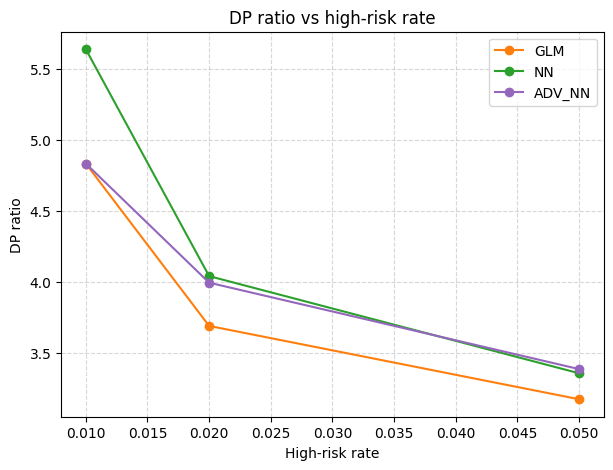

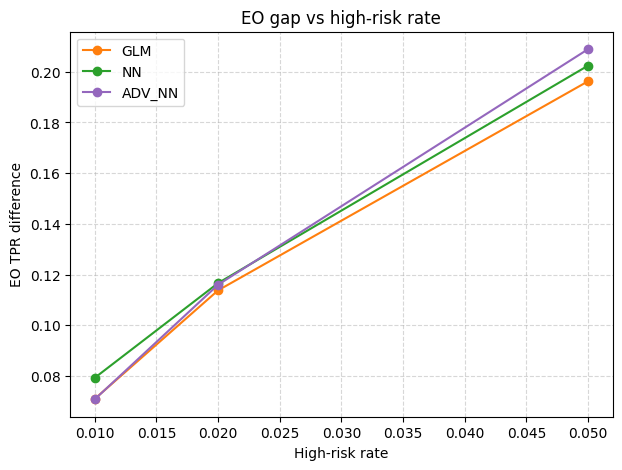

In [12]:
fig, ax = plt.subplots(figsize=(7, 5))
for model, color in colors.items():
    subset = df_rates[df_rates['model'] == model].sort_values('target_rate')
    ax.plot(subset['target_rate'], subset['dp_ratio'], marker='o', color=color, label=model)
ax.set_xlabel('High-risk rate')
ax.set_ylabel('DP ratio')
ax.set_title('DP ratio vs high-risk rate')
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(7, 5))
for model, color in colors.items():
    subset = df_rates[df_rates['model'] == model].sort_values('target_rate')
    ax.plot(subset['target_rate'], subset['eo_gap_tpr'], marker='o', color=color, label=model)
ax.set_xlabel('High-risk rate')
ax.set_ylabel('EO TPR difference')
ax.set_title('EO gap vs high-risk rate')
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend()
plt.show()


### 9.1 Predicted score distributions by Race\n

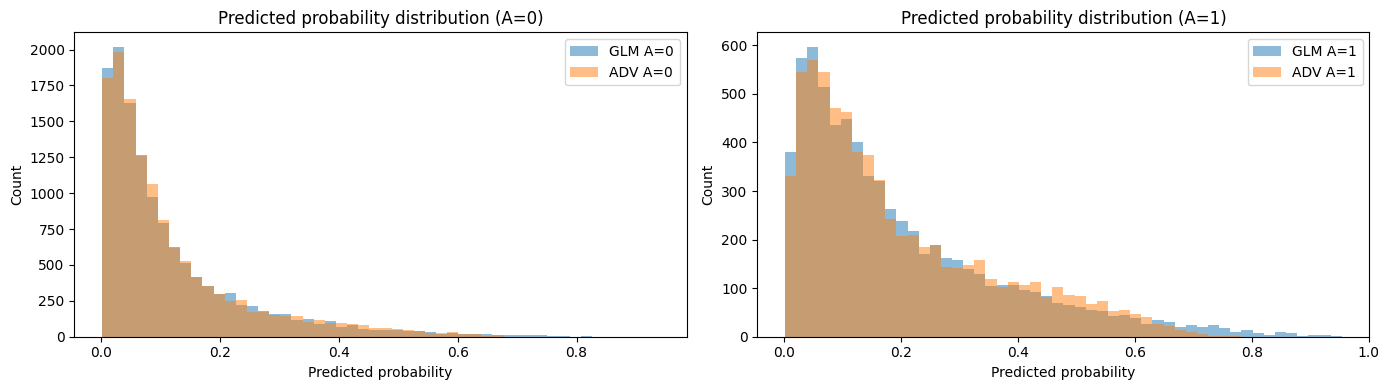

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

for ax, group in zip(axes, [0, 1]):
    mask = (A_test == group)

    # Build common bin edges from the union of GLM + ADV scores for this group
    all_scores = np.concatenate([y_proba_glm[mask], y_proba_adv[mask]])
    bins = np.linspace(all_scores.min(), all_scores.max(), 51)  # 50 bins

    # Plot histograms using the same bins
    ax.hist(y_proba_glm[mask], bins=bins, alpha=0.5, label=f"GLM A={group}")
    ax.hist(y_proba_adv[mask], bins=bins, alpha=0.5, label=f"ADV A={group}")

    ax.set_title(f"Predicted probability distribution (A={group})")
    ax.set_xlabel("Predicted probability")
    ax.set_ylabel("Count")
    ax.legend()

plt.tight_layout()
plt.show()


### 9.2 Simulated variable distributions


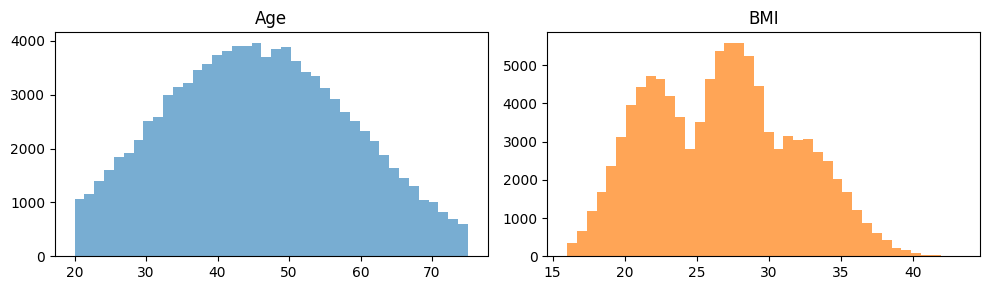

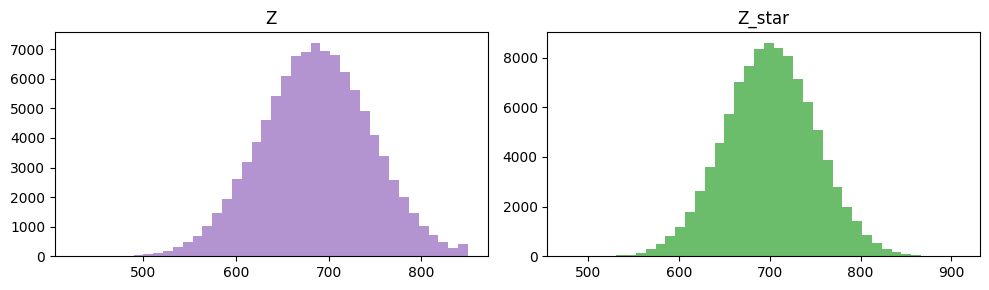

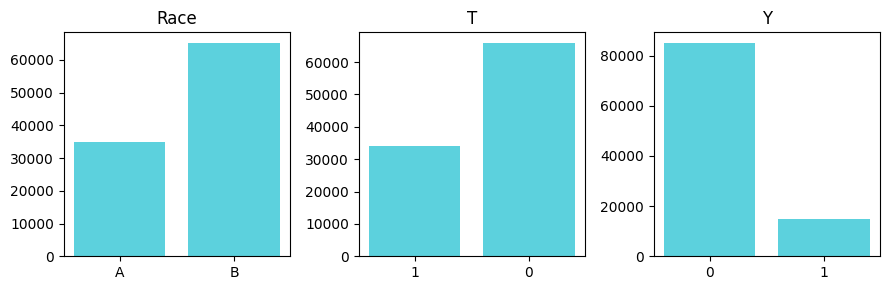

In [14]:
numeric_pairs_1 = ['Age', 'BMI']
numeric_pairs_2 = ['Z', 'Z_star']
binary_cols = ['Race', 'T', 'Y']

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes = axes.ravel()
axes[0].hist(df[numeric_pairs_1[0]], bins=40, color='tab:blue', alpha=0.6)
axes[0].set_title(numeric_pairs_1[0])
axes[1].hist(df[numeric_pairs_1[1]], bins=40, color='tab:orange', alpha=0.7)
axes[1].set_title(numeric_pairs_1[1])
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes = axes.ravel()
axes[0].hist(df[numeric_pairs_2[0]], bins=40, color='tab:purple', alpha=0.7)
axes[0].set_title(numeric_pairs_2[0])
axes[1].hist(df[numeric_pairs_2[1]], bins=40, color='tab:green', alpha=0.7)
axes[1].set_title(numeric_pairs_2[1])
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, len(binary_cols), figsize=(3 * len(binary_cols), 3))
for ax, col in zip(axes, binary_cols):
    counts = df[col].value_counts().reindex(df[col].unique(), fill_value=0)
    ax.bar(counts.index.astype(str), counts.values, color='tab:cyan', alpha=0.7)
    ax.set_title(col)
plt.tight_layout()
plt.show()


### 9.3 Fairness frontier (lambda sweep; threshold 0.5 and 2% target)


In [15]:
lambda_values = [0.05, 0.1, 0.2, 0.3, 0.5, 0.8, 1.2, 2.0]
rows_05 = []
rows_02 = []
for lam in lambda_values:
    cfg_lam = replace(train_cfg, lambda_adv=lam)
    adv_model_lam = AdvPredictor(input_dim=X_train.shape[1]).to(device)
    train_adv_nn(adv_model_lam, adv_loader, cfg_lam, device=device)
    y_proba_lam = predict_proba_adv_nn(adv_model_lam, X_test, device=device)
    acc = compute_accuracy_metrics(y_test, y_proba_lam)
    fair_05 = fairness_metrics(y_test, y_proba_lam, A_test, threshold=0.5)
    fair_02 = fairness_at_target_rate(y_test, y_proba_lam, A_test, target_rate=0.02)
    rows_05.append({'model': 'ADV_NN', 'lambda_adv': lam, **acc, **fair_05})
    rows_02.append({'model': 'ADV_NN', 'lambda_adv': lam, **acc, **fair_02})

df_lambda_05 = pd.DataFrame(rows_05)
df_lambda_02 = pd.DataFrame(rows_02)

base_rows_05 = []
for name, y_pred in [('GLM', y_proba_glm), ('NN', y_proba_nn)]:
    acc = compute_accuracy_metrics(y_test, y_pred)
    fair = fairness_metrics(y_test, y_pred, A_test, threshold=0.5)
    base_rows_05.append({'model': name, **acc, **fair})
df_base_05 = pd.DataFrame(base_rows_05)

df_base_02 = summary_fixed.rename(columns={'threshold': 'threshold_fixed_r'}).copy()

df_frontier_05 = pd.concat([df_lambda_05, df_base_05], ignore_index=True)
df_frontier_02 = pd.concat([df_lambda_02, df_base_02], ignore_index=True)


Epoch 0 [warmup]
Epoch 1 [warmup]
Epoch 2 [warmup]
Epoch 3 [warmup]
Epoch 4 [warmup]
Epoch 5 [adversarial]
Epoch 6 [adversarial]
Epoch 7 [adversarial]
Epoch 8 [adversarial]
Epoch 9 [adversarial]
Epoch 0 [warmup]
Epoch 1 [warmup]
Epoch 2 [warmup]
Epoch 3 [warmup]
Epoch 4 [warmup]
Epoch 5 [adversarial]
Epoch 6 [adversarial]
Epoch 7 [adversarial]
Epoch 8 [adversarial]
Epoch 9 [adversarial]
Epoch 0 [warmup]
Epoch 1 [warmup]
Epoch 2 [warmup]
Epoch 3 [warmup]
Epoch 4 [warmup]
Epoch 5 [adversarial]
Epoch 6 [adversarial]
Epoch 7 [adversarial]
Epoch 8 [adversarial]
Epoch 9 [adversarial]
Epoch 0 [warmup]
Epoch 1 [warmup]
Epoch 2 [warmup]
Epoch 3 [warmup]
Epoch 4 [warmup]
Epoch 5 [adversarial]
Epoch 6 [adversarial]
Epoch 7 [adversarial]
Epoch 8 [adversarial]
Epoch 9 [adversarial]
Epoch 0 [warmup]
Epoch 1 [warmup]
Epoch 2 [warmup]
Epoch 3 [warmup]
Epoch 4 [warmup]
Epoch 5 [adversarial]
Epoch 6 [adversarial]
Epoch 7 [adversarial]
Epoch 8 [adversarial]
Epoch 9 [adversarial]
Epoch 0 [warmup]
Epoch 1 

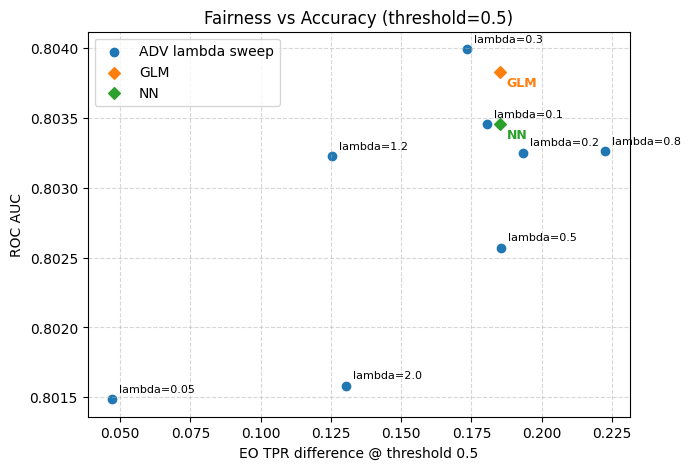

In [16]:
fig, ax = plt.subplots(figsize=(7,5))
ax.grid(True, linestyle='--', alpha=0.5)
colors = {'GLM':'tab:orange','NN':'tab:green','ADV_NN':'tab:purple'}
lambda_pts = df_frontier_05[df_frontier_05['model']=='ADV_NN']
if not lambda_pts.empty:
    ax.scatter(lambda_pts['eo_gap_tpr'], lambda_pts['roc_auc'], c='tab:blue', label='ADV lambda sweep')
    for _, row in lambda_pts.iterrows():
        ax.annotate(f"lambda={row['lambda_adv']}", (row['eo_gap_tpr'], row['roc_auc']), textcoords='offset points', xytext=(5,5), fontsize=8)
for model in ['GLM','NN']:
    subset = df_frontier_05[df_frontier_05['model']==model]
    if subset.empty:
        continue
    row = subset.iloc[0]
    ax.scatter(row['eo_gap_tpr'], row['roc_auc'], c=colors[model], marker='D', label=model)
    ax.annotate(model, (row['eo_gap_tpr'], row['roc_auc']), textcoords='offset points', xytext=(5,-10), fontsize=9, fontweight='bold', color=colors[model])
ax.set_xlabel('EO TPR difference @ threshold 0.5')
ax.set_ylabel('ROC AUC')
ax.set_title('Fairness vs Accuracy (threshold=0.5)')
ax.legend()
plt.show()


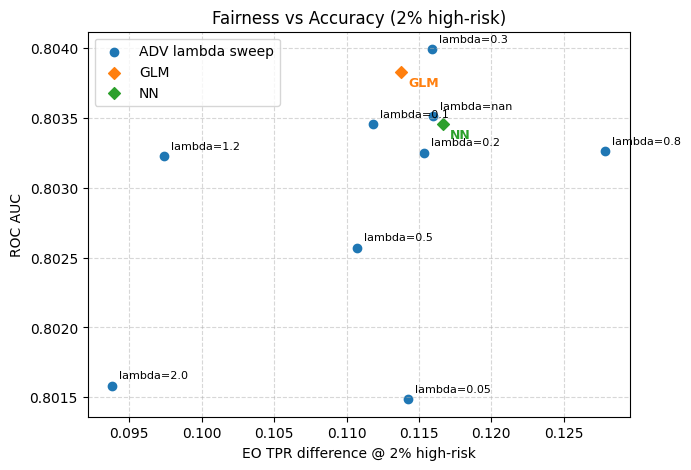

In [17]:
fig, ax = plt.subplots(figsize=(7,5))
ax.grid(True, linestyle='--', alpha=0.5)
lambda_pts = df_frontier_02[df_frontier_02['model']=='ADV_NN']
if not lambda_pts.empty:
    ax.scatter(lambda_pts['eo_gap_tpr'], lambda_pts['roc_auc'], c='tab:blue', label='ADV lambda sweep')
    for _, row in lambda_pts.iterrows():
        ax.annotate(f"lambda={row['lambda_adv']}", (row['eo_gap_tpr'], row['roc_auc']), textcoords='offset points', xytext=(5,5), fontsize=8)
for model in ['GLM','NN']:
    subset = df_frontier_02[df_frontier_02['model']==model]
    if subset.empty:
        continue
    row = subset.iloc[0]
    ax.scatter(row['eo_gap_tpr'], row['roc_auc'], c=colors.get(model, 'tab:gray'), marker='D', label=model)
    ax.annotate(model, (row['eo_gap_tpr'], row['roc_auc']), textcoords='offset points', xytext=(5,-10), fontsize=9, fontweight='bold', color=colors.get(model, 'black'))
ax.set_xlabel('EO TPR difference @ 2% high-risk')
ax.set_ylabel('ROC AUC')
ax.set_title('Fairness vs Accuracy (2% high-risk)')
ax.legend()
plt.show()


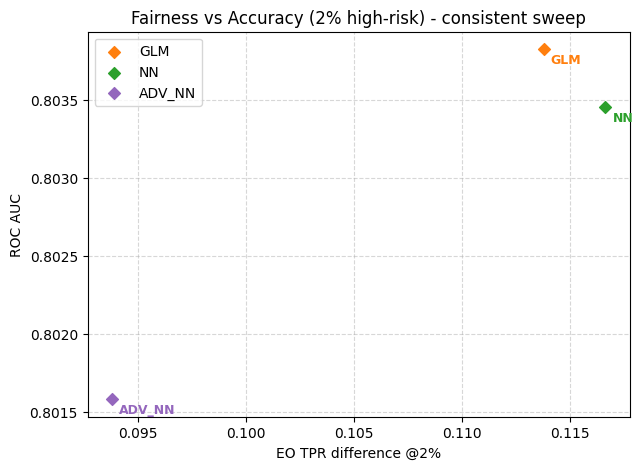

In [18]:
# Pick ADV lambda with best trade-off and align plot to sweep
lambda_pts = df_frontier_02[df_frontier_02['model']=='ADV_NN'].copy()
if not lambda_pts.empty:
    lambda_pts['score'] = lambda_pts['roc_auc'] - 0.5 * lambda_pts['eo_gap_tpr'].abs()
    best_adv = lambda_pts.sort_values('score', ascending=False).iloc[0]
    adv_row = best_adv.to_dict()
    adv_row['model'] = 'ADV_NN'
else:
    adv_row = None

base_rows = []
for model in ['GLM','NN']:
    subset = df_frontier_02[df_frontier_02['model']==model]
    if subset.empty:
        continue
    base_rows.append(subset.iloc[0])
if adv_row is not None:
    base_rows.append(pd.Series(adv_row))
summary_consistent = pd.DataFrame(base_rows)

fig, ax = plt.subplots(figsize=(7, 5))
ax.grid(True, linestyle='--', alpha=0.5)
for _, row in summary_consistent.iterrows():
    ax.scatter(row['eo_gap_tpr'], row['roc_auc'], color=colors.get(row['model'], 'tab:blue'), marker='D', label=row['model'])
    ax.annotate(row['model'], (row['eo_gap_tpr'], row['roc_auc']), textcoords='offset points', xytext=(5, -10), fontsize=9, fontweight='bold', color=colors.get(row['model'], 'black'))
ax.set_title('Fairness vs Accuracy (2% high-risk) - consistent sweep')
ax.set_xlabel('EO TPR difference @2%')
ax.set_ylabel('ROC AUC')
ax.legend()
plt.show()


## 10. Summary

In [19]:
text = (
    "### Key Insights (Life Underwriting - Decline Decisions)"
    f"- At ~{100*DECLINE_RATE:.0f}% decline rate, GLM achieves ROC AUC "
    f"{summary_decline.loc[summary_decline.model=='GLM', 'roc_auc'].iat[0]:.3f} "
    f"with EO gap (TPR) "
    f"{summary_decline.loc[summary_decline.model=='GLM', 'eo_gap_tpr'].iat[0]:.3f} "
    f"and DP ratio "
    f"{summary_decline.loc[summary_decline.model=='GLM', 'dp_ratio'].iat[0]:.2f}."
    f"- The plain NN typically improves AUC "
    f"({summary_decline.loc[summary_decline.model=='NN', 'roc_auc'].iat[0]:.3f}) "
    f"but may widen Race A/B gaps in decline decisions."
    f"- The adversarial NN (proxy-aware on T) trades a bit of AUC "
    f"({summary_decline.loc[summary_decline.model=='ADV_NN', 'roc_auc'].iat[0]:.3f}) "
    f"for smaller EO/DP gaps in decline decisions, by discouraging use of "
    f"the territory proxy T in the hidden representation."
)
print(text)

### Key Insights (Life Underwriting - Decline Decisions)- At ~2% decline rate, GLM achieves ROC AUC 0.804 with EO gap (TPR) 0.114 and DP ratio 3.69.- The plain NN typically improves AUC (0.803) but may widen Race A/B gaps in decline decisions.- The adversarial NN (proxy-aware on T) trades a bit of AUC (0.804) for smaller EO/DP gaps in decline decisions, by discouraging use of the territory proxy T in the hidden representation.
